# Interactive Grad-CAM Visualization

This notebook provides interactive visualization of Grad-CAM (Gradient-weighted Class Activation Mapping) for incorrectly predicted MNIST images.

## How to Run

1. **Run cells sequentially from top to bottom** (Cells 1-6) to:
   - Import required libraries
   - Load the trained model and incorrect predictions
   - Define helper functions

2. **Interactive Visualization**:
   - **Cell 7**: Use `visualize_grad_cam(j)` to visualize a specific incorrect prediction
   - Change the index `j` (0 to len(incorrect_preds)-1) to view different examples
   - Example: `visualize_grad_cam(20)` shows the 21st incorrect prediction

## Key Functions

- `get_grad_cam_by_incorrect_pred_idx(j)`: Returns grad-cam attribution for the j-th incorrect prediction
- `visualize_grad_cam(j)`: Displays the image with grad-cam heatmap overlay

## Note

The visualization shows:
- **Original grayscale image**: The input digit
- **Heatmap overlay**: Red/yellow areas indicate features that influenced the model's (incorrect) prediction
- **Title**: Shows the predicted label vs. true label

In [1]:
import sys
sys.path.append('..')
from captum.attr import IntegratedGradients, Saliency, DeepLift
from NNModel import MultiLayerNN
from captum.attr import visualization as viz
import numpy as np
import pickle
import torch
import torch.nn as nn
from prep_data import prep_data
import matplotlib.pyplot as plt

/work/hzeng_umass_edu/miniconda3/envs/verl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Prep

In [2]:
train_loader, test_loader = prep_data()
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

100%|██████████| 9.91M/9.91M [01:37<00:00, 101kB/s] 

100%|██████████| 28.9k/28.9k [00:00<00:00, 1.00MB/s]

100%|██████████| 1.65M/1.65M [00:08<00:00, 184kB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 474kB/s]



In [3]:
MODEL_PATH = "../data/model.pt"
INCORRECT_PRED_PATH = "../data/incorrect_preds.pkl"
    

state_dict = torch.load(MODEL_PATH, weights_only=True)
new_dict = {}
#When model compiles, all weights are modified from LAYERNAME to _orig_model.LAYERNAME. We remove the _orig_model. for compatibility
for k in state_dict.keys():
    new_dict[k[10:]] = state_dict[k]
model = MultiLayerNN(latent_size=128, num_layers=3)
model.load_state_dict(new_dict)
model.to(device)

with open(INCORRECT_PRED_PATH, "rb") as f:
    incorrect_preds = pickle.load(f)

Predicted: 3, True: 5


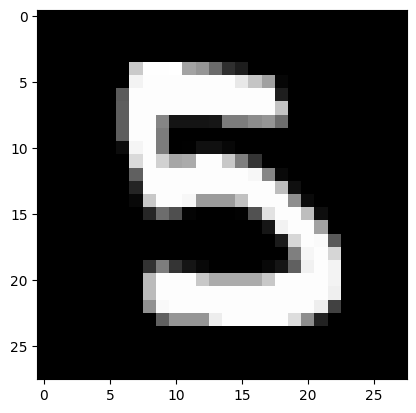

In [4]:
# Build a mapping from idx to image
# Since train_loader has shuffle=True, we need to get the original dataset
# Also you can do interactively picking
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset

# Create a function to get image by idx
def get_image_by_idx(idx):
    """Get image from dataset by index"""
    if idx < len(train_dataset):
        img, _, _ = train_dataset[idx]
        return img
    else:
        # Adjust index for test set
        test_idx = idx - len(train_dataset)
        img, _, _ = test_dataset[test_idx]
        return img

# Test: visualize first incorrect prediction
first_idx, pred_label, true_label = incorrect_preds[3]
first_img = get_image_by_idx(first_idx)
plt.imshow(first_img.squeeze(), cmap="gray")
print(f"Predicted: {pred_label}, True: {true_label}")

In [5]:
# get grad_cam based on the index
def get_grad_cam_by_incorrect_pred_idx(j):
    """
    Get Grad-CAM attribution for a specific incorrect prediction
    
    Args:
        j: index in the incorrect_preds list
    
    Returns:
        tuple: (original_image, attribution, idx, pred_class, true_class)
    """
    # Get the prediction info
    idx, pred_class, true_class = incorrect_preds[j]
    
    # Get the original image
    original_image = get_image_by_idx(idx)
    
    # Prepare input for the model
    input_img = original_image.unsqueeze(0).to(device)  # Add batch dimension
    
    # Get the model's prediction
    output = model(input_img.reshape(-1, 28 * 28))
    pred_probs = nn.functional.softmax(output, dim=1)
    pred_class_tensor = torch.argmax(pred_probs, dim=-1)
    
    # Create baseline (all zeros)
    baseline = torch.zeros_like(input_img.reshape(-1, 28*28)).to(device)
    
    # Calculate attributions using Integrated Gradients
    ig = IntegratedGradients(model)
    attribution = ig.attribute(input_img.reshape(-1, 28*28), 
                              baselines=baseline, 
                              target=pred_class_tensor)
    
    # Reshape attribution to image size
    attribution = attribution.detach().cpu().reshape(28, 28)
    
    return original_image, attribution, idx, pred_class, true_class


def visualize_grad_cam(j):
    """
    Visualize Grad-CAM for a specific incorrect prediction
    
    Args:
        j: index in the incorrect_preds list
    """
    original_image, attribution, idx, pred_class, true_class = get_grad_cam_by_incorrect_pred_idx(j)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(original_image.squeeze(), cmap="gray")
    im = ax.imshow(attribution.squeeze(), cmap="jet", alpha=0.5)
    ax.set_title(f"Prediction: {pred_class}, True Label: {true_class}", fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    
    print(f"Showing incorrect prediction #{j+1}/{len(incorrect_preds)}")
    print(f"Image index: {idx}, Predicted: {pred_class}, True: {true_class}")
    
    return fig, ax

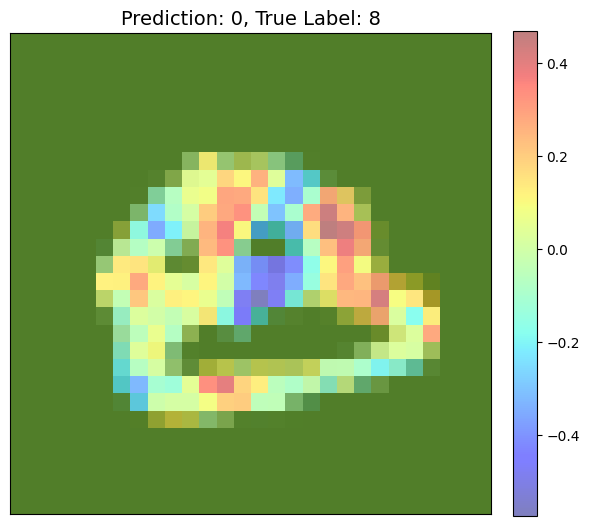

Showing incorrect prediction #21/1500
Image index: 47597, Predicted: 0, True: 8


(<Figure size 600x600 with 2 Axes>,
 <Axes: title={'center': 'Prediction: 0, True Label: 8'}>)

In [8]:
visualize_grad_cam(20)